In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50


In [2]:
import os
# Ana dizindeki dosya ve klasörleri listele
print(os.listdir("../input"))

# DatathonAI Qualification Round klasörünü kontrol et
data_path = "../input/datathon-ai-qualification-round"
print(os.listdir(data_path))


['datathon-ai-qualification-round']
['train_data.csv', 'test.csv', 'test', 'train']


In [3]:
# CSV dosyalarının tam yolunu belirle
train_csv_path = os.path.join(data_path, "train_data.csv")
test_csv_path = os.path.join(data_path, "test.csv")

# CSV dosyalarını pandas ile oku
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# İlk birkaç satırı görüntüle
print("Train DataFrame:")
print(train_df.head())

print("\nTest DataFrame:")
print(test_df.head())


Train DataFrame:
          filename      city
0  image_10000.jpg  Istanbul
1  image_10001.jpg  Istanbul
2  image_10002.jpg    Ankara
3  image_10003.jpg     Izmir
4  image_10004.jpg    Ankara

Test DataFrame:
          filename  city
0  image_17000.jpg   NaN
1  image_17001.jpg   NaN
2  image_17002.jpg   NaN
3  image_17003.jpg   NaN
4  image_17004.jpg   NaN


In [4]:
# Görsel dizinlerini belirle
train_images_path = os.path.join(data_path, "/kaggle/input/datathon-ai-qualification-round/train/train")
test_images_path = os.path.join(data_path, "/kaggle/input/datathon-ai-qualification-round/test/test")

# Eğitim görsellerine tam yol ekle
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(train_images_path, x))

# Test görsellerine tam yol ekle
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_images_path, x))

# Güncellenmiş DataFrame'i kontrol et
print(train_df.head())


          filename      city  \
0  image_10000.jpg  Istanbul   
1  image_10001.jpg  Istanbul   
2  image_10002.jpg    Ankara   
3  image_10003.jpg     Izmir   
4  image_10004.jpg    Ankara   

                                            filepath  
0  /kaggle/input/datathon-ai-qualification-round/...  
1  /kaggle/input/datathon-ai-qualification-round/...  
2  /kaggle/input/datathon-ai-qualification-round/...  
3  /kaggle/input/datathon-ai-qualification-round/...  
4  /kaggle/input/datathon-ai-qualification-round/...  


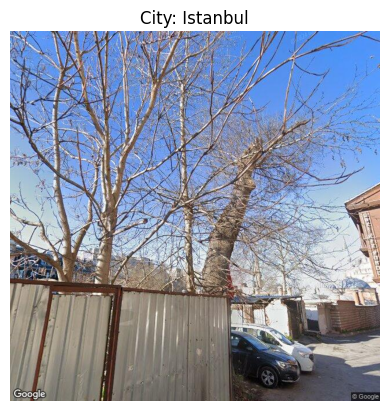

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

# Eğitim verisinden bir görsel göster
sample_image_path = train_df['filepath'].iloc[0]
img = Image.open(sample_image_path)
plt.imshow(img)
plt.title(f"City: {train_df['city'].iloc[0]}")
plt.axis("off")
plt.show()


Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7000 non-null   object
 1   city      7000 non-null   object
 2   filepath  7000 non-null   object
dtypes: object(3)
memory usage: 164.2+ KB
None

Train DataFrame Description:
               filename    city  \
count              7000    7000   
unique             7000       3   
top     image_16999.jpg  Ankara   
freq                  1    2360   

                                                 filepath  
count                                                7000  
unique                                               7000  
top     /kaggle/input/datathon-ai-qualification-round/...  
freq                                                    1  

City distribution:
city
Ankara      2360
Izmir       2322
Istanbul    2318
Name: count, dtype: int64


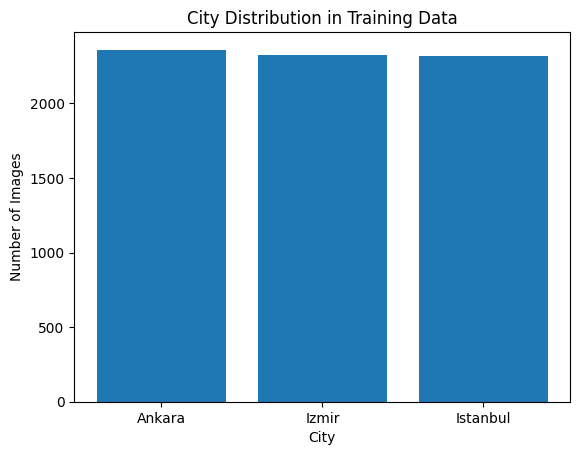

In [6]:
# Eğitim verisini keşfet
print("Train DataFrame Info:")
print(train_df.info())  # Veri tipleri ve eksik verileri gösterir
print("\nTrain DataFrame Description:")
print(train_df.describe())  # Sayısal özet
print("\nCity distribution:")
print(train_df['city'].value_counts())  # Şehirlerin dağılımı

# Görsellerin dağılımını kontrol et
import matplotlib.pyplot as plt

city_counts = train_df['city'].value_counts()
plt.bar(city_counts.index, city_counts.values)
plt.title("City Distribution in Training Data")
plt.xlabel("City")
plt.ylabel("Number of Images")
plt.show()


In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['city_label'] = label_encoder.fit_transform(train_df['city'])

print("City Labels:")
print(dict(enumerate(label_encoder.classes_)))


City Labels:
{0: 'Ankara', 1: 'Istanbul', 2: 'Izmir'}


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Görsel boyutu
IMAGE_SIZE = (224, 224)  # Model için standart bir boyut
BATCH_SIZE = 32

# Eğitim verisi için ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Eğitim ve doğrulama setlerini oluştur
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_path,
    x_col="filename",
    y_col="city_label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="training"
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_path,
    x_col="filename",
    y_col="city_label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation"
)


Found 5600 validated image filenames.
Found 1400 validated image filenames.


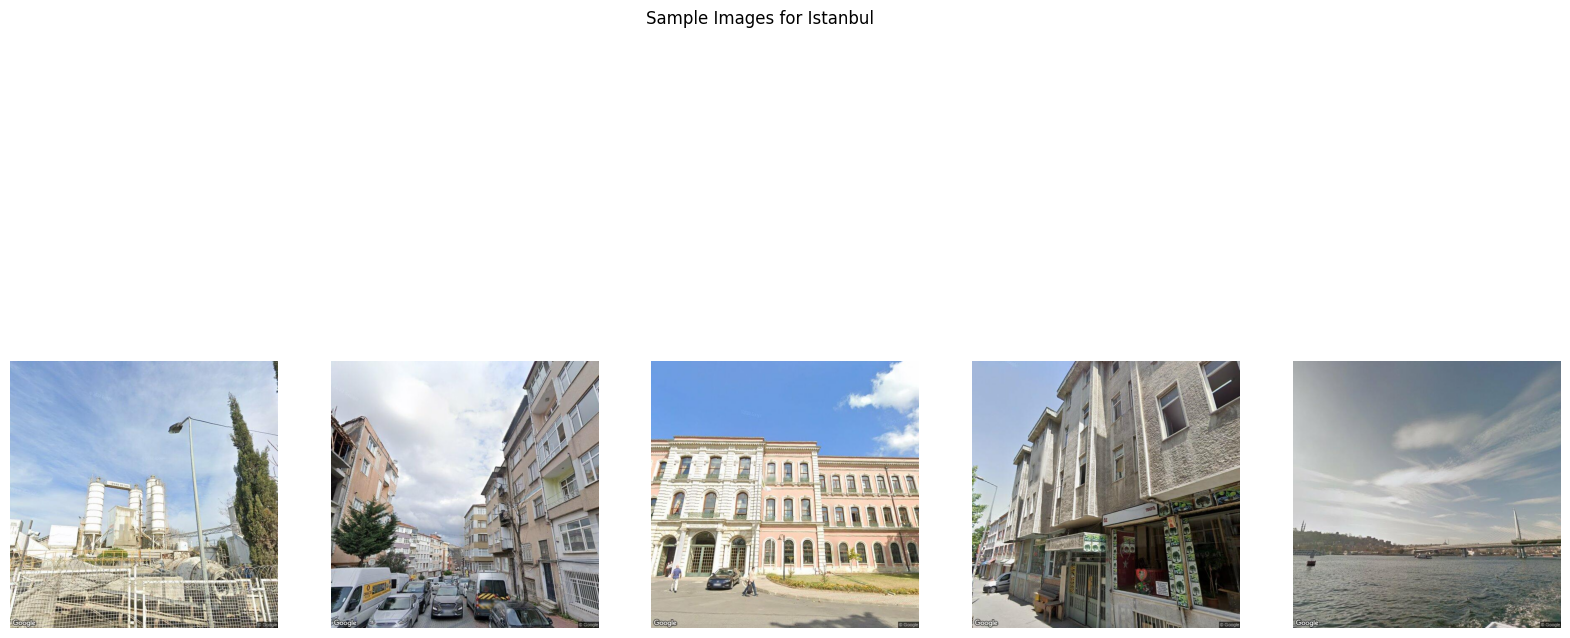

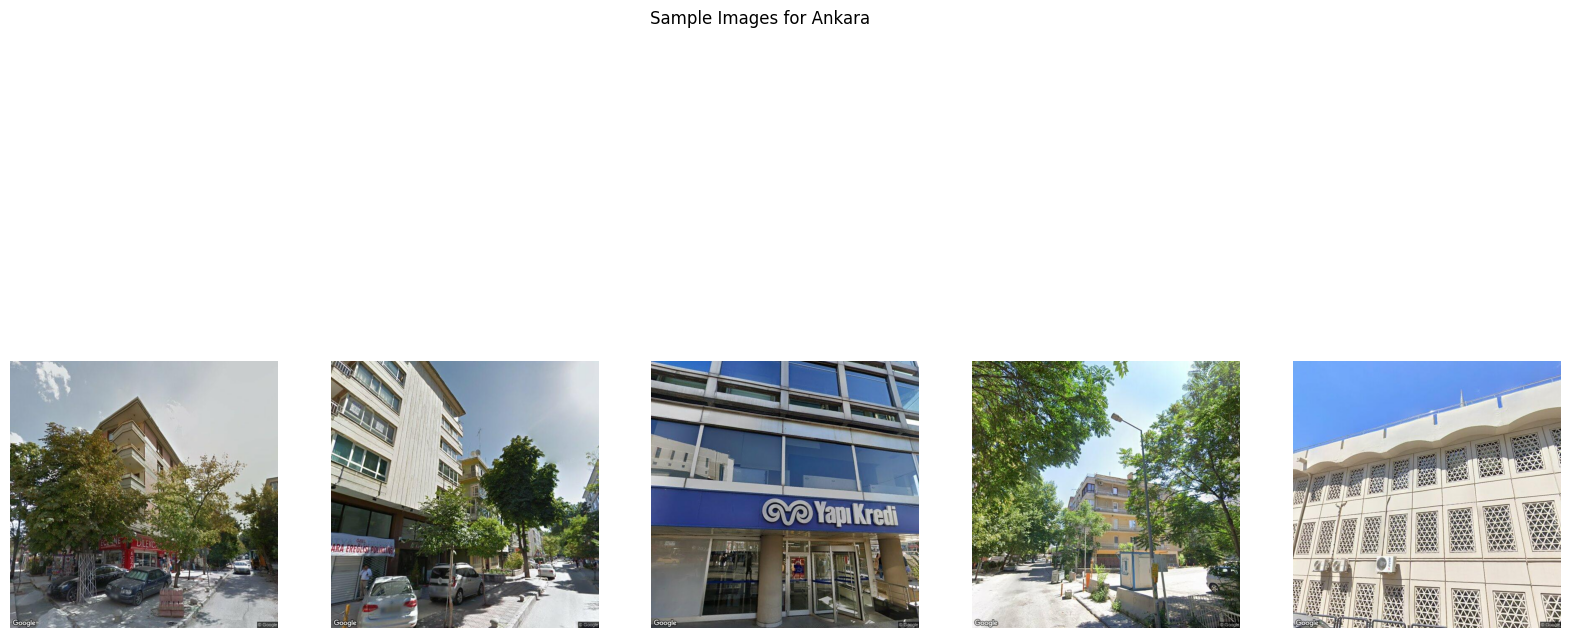

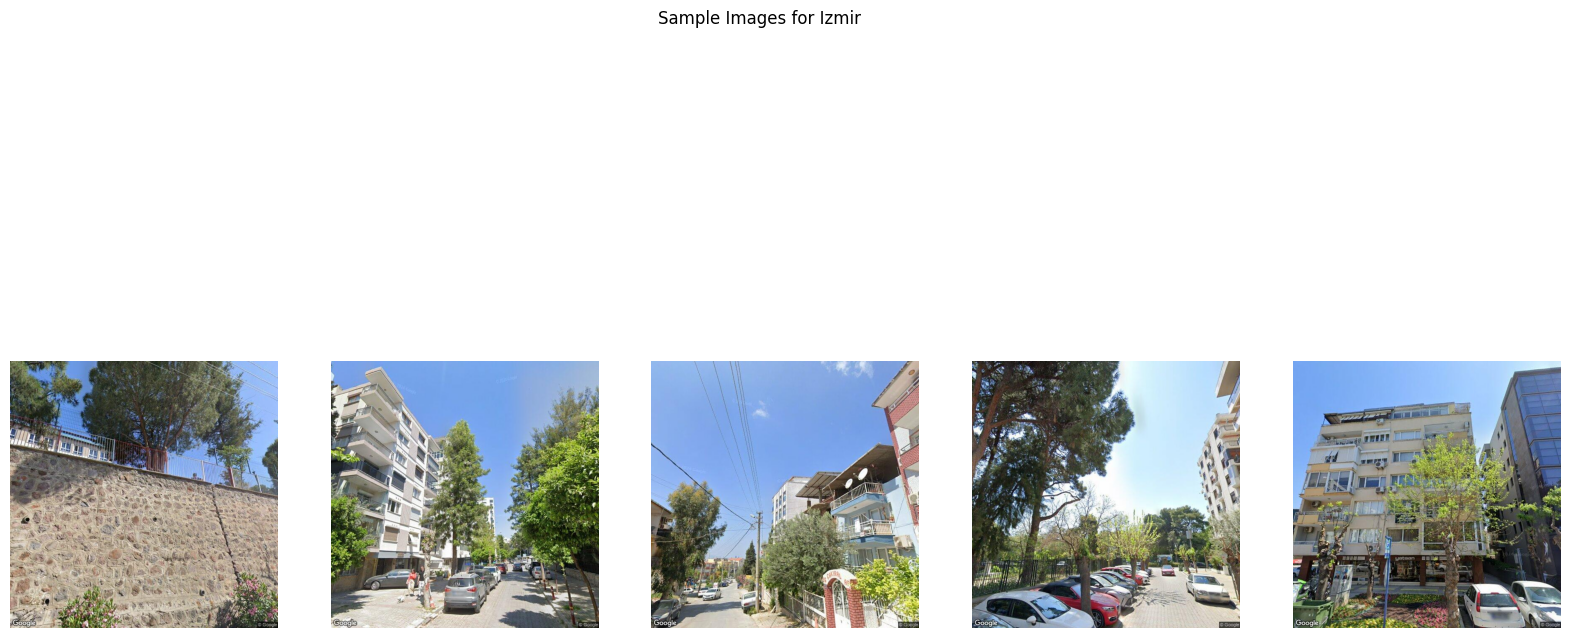

In [9]:
for city in train_df['city'].unique():
    sample_images = train_df[train_df['city'] == city].sample(5)['filepath']
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))
    fig.suptitle(f"Sample Images for {city}")
    for i, filepath in enumerate(sample_images):
        img = Image.open(filepath)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Renk değişiklikleri
    channel_shift_range=50,  # Renk kanallarını kaydırma
    validation_split=0.2
)


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,           # Görseli 30 dereceye kadar döndürme
    width_shift_range=0.2,       # Genişlik kaydırması
    height_shift_range=0.2,      # Yükseklik kaydırması
    shear_range=0.2,             # Şeritleme (shear) dönüşümü
    zoom_range=0.2,              # Yakınlaştırma
    horizontal_flip=True,        # Görselleri yatay çevirme
    brightness_range=[0.8, 1.2], # Parlaklık ayarı (daha karanlık veya aydınlık)
    validation_split=0.2         # Eğitim ve doğrulama seti ayrımı
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_path,
    x_col="filename",
    y_col="city",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_path,
    x_col="filename",
    y_col="city",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 5600 validated image filenames belonging to 3 classes.
Found 1400 validated image filenames belonging to 3 classes.


In [12]:
# Geliştirilmiş veri artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,         # Görselleri rastgele döndürme
    width_shift_range=0.2,     # Yatay kaydırma
    height_shift_range=0.2,    # Dikey kaydırma
    shear_range=0.2,           # Şekil bozulması
    zoom_range=0.2,            # Rastgele yakınlaştırma
    brightness_range=[0.8, 1.2],  # Parlaklık değişiklikleri
    horizontal_flip=True,      # Yatay döndürme
    validation_split=0.2       # Eğitim ve doğrulama için ayrım
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734303247.121484      73 service.cc:145] XLA service 0x7e07ec001df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734303247.121540      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734303247.121543      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734303254.239838      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.3818 - loss: 1.2514

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.14136, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 10s/step - accuracy: 0.3702 - loss: 1.2583 - val_accuracy: 0.3771 - val_loss: 1.1414 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.3727 - loss: 1.1286
Epoch 2: val_loss improved from 1.14136 to 1.13572, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.3668 - loss: 1.1333 - val_accuracy: 0.3350 - val_loss: 1.1357 - learning_rate: 1.0000e-04
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3500 - loss: 1.2057
Epoch 3: val_loss improved from 1.13572 to 1.12439, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.3438 - loss: 1.2138 - val_accuracy: 0.3357 - val_loss: 1.1244 - learning_rate: 1.0000e-04
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3021 - loss: 1.1725
Epoch 4: val_loss improved from 1.12439 to 1.11512, saving model to best_

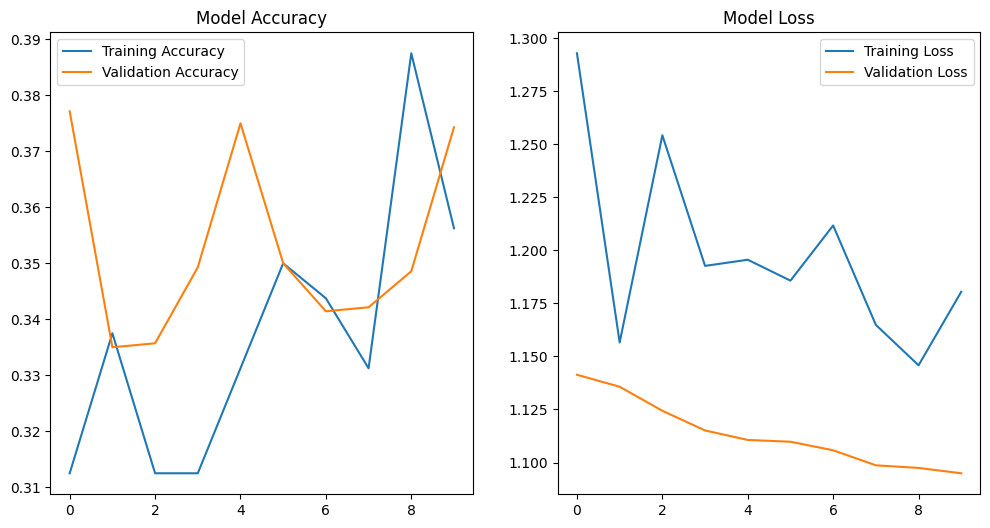

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.3632 - loss: 1.7721
Epoch 1: val_loss did not improve from 1.09493
175/175 ━━━━━━━━━━━━━━━━━━━━ 181s 696ms/step - accuracy: 0.3635 - loss: 1.7709 - val_accuracy: 0.3150 - val_loss: 6.1537 - learning_rate: 1.0000e-05
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5448 - loss: 1.2250
Epoch 2: val_loss did not improve from 1.09493
175/175 ━━━━━━━━━━━━━━━━━━━━ 108s 599ms/step - accuracy: 0.5449 - loss: 1.2247 - val_accuracy: 0.3436 - val_loss: 4.5902 - learning_rate: 1.0000e-05
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.6370 - loss: 1.0179
Epoch 3: val_loss did not improve from 1.09493
175/175 ━━━━━━━━━━━━━━━━━━━━ 109s 602ms/step - accuracy: 0.6370 - loss: 1.0178 - val_accuracy: 0.3879 - val_loss: 2.4995 - learning_rate: 1.0000e-05
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.6638 - loss: 0.9007
Epoch 4: val_loss did not improve from 1.09493
175/175 ━━━━━

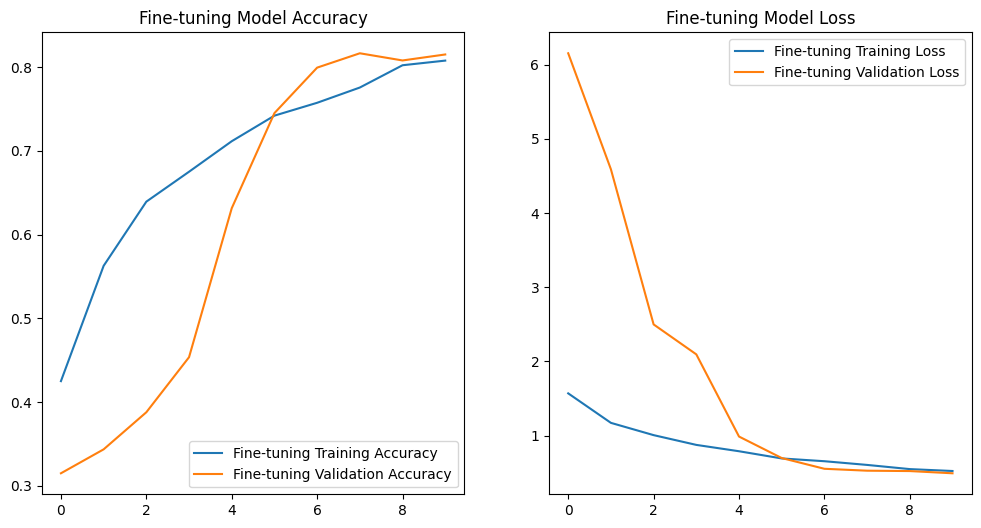

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# 1. Sınıf sayısını belirle
num_classes = len(train_generator.class_indices)

# 2. Önceden eğitilmiş ResNet50 modeli ile transfer öğrenme
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 3. Base modelin katmanlarını dondurma (Transfer Learning için)
for layer in base_model.layers:
    layer.trainable = False

# 4. Modelin üzerine katmanlar ekle
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Flatten yerine Global Average Pooling kullanılıyor
    BatchNormalization(),      # Model stabilitesini artırır
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# 5. Modeli derle (Optimizer'ı ayarla)
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Öğrenme oranını ayarlayın
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Callbacks ekle
checkpoint = ModelCheckpoint(
    "best_model.keras",  # En iyi modeli kaydet
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# EarlyStopping ile overfitting'i engelle
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

tensorboard_callback = TensorBoard(
    log_dir='logs/',  # TensorBoard ile izleme
    histogram_freq=1
)

# 7. Modeli eğit
batch_size = 32  # Batch boyutunu belirleyin

steps_per_epoch = len(train_generator) // batch_size
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=[checkpoint, lr_scheduler, tensorboard_callback, early_stopping]
)


# 8. Model performansını değerlendirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.show()

# 9. Base modelin katmanlarını açarak ince ayar (Fine-tuning)
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Daha düşük öğrenme oranı ile ince ayar
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 10. İnce ayar yaparak yeniden eğitme
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Daha kısa epoch ile ince ayar
    callbacks=[checkpoint, lr_scheduler, tensorboard_callback, early_stopping]
)

# İnce ayar sonrası performans değerlendirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Fine-tuning Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.legend()
plt.title("Fine-tuning Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Fine-tuning Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-tuning Validation Loss')
plt.legend()
plt.title("Fine-tuning Model Loss")

plt.show()

In [14]:
# Test verisini hazırlama
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_images_path,
    x_col="filename",
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Tahmin yap
predictions = model.predict(test_generator)
predicted_labels = predictions.argmax(axis=1)

# Tahminleri çöz
test_df['city'] = label_encoder.inverse_transform(predicted_labels)

# İlk birkaç tahmini kontrol et
print(test_df.head())

Found 2000 validated image filenames.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step
          filename      city  \
0  image_17000.jpg     Izmir   
1  image_17001.jpg    Ankara   
2  image_17002.jpg  Istanbul   
3  image_17003.jpg  Istanbul   
4  image_17004.jpg     Izmir   

                                            filepath  
0  /kaggle/input/datathon-ai-qualification-round/...  
1  /kaggle/input/datathon-ai-qualification-round/...  
2  /kaggle/input/datathon-ai-qualification-round/...  
3  /kaggle/input/datathon-ai-qualification-round/...  
4  /kaggle/input/datathon-ai-qualification-round/...  


In [15]:
# Gerekli formatta bir CSV dosyası oluştur
submission_df = test_df[['filename', 'city']]
submission_path = "submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved to {submission_path}")

Submission file saved to submission.csv


In [16]:
# Eğitim doğruluğu (accuracy) ve kaybı (loss) verilerini görüntüle
print("Training Accuracy:")
print(history.history['accuracy'])  # Eğitim doğruluğu
print("\nValidation Accuracy:")
print(history.history['val_accuracy'])  # Doğrulama doğruluğu

# Eğitim kaybı (loss) ve doğrulama kaybını görüntüle
print("\nTraining Loss:")
print(history.history['loss'])  # Eğitim kaybı
print("\nValidation Loss:")
print(history.history['val_loss'])  # Doğrulama kaybı

Training Accuracy:
[0.3125, 0.3375000059604645, 0.3125, 0.3125, 0.33125001192092896, 0.3499999940395355, 0.34375, 0.33125001192092896, 0.38749998807907104, 0.35624998807907104]

Validation Accuracy:
[0.37714284658432007, 0.33500000834465027, 0.33571428060531616, 0.34928572177886963, 0.375, 0.3499999940395355, 0.34142857789993286, 0.34214285016059875, 0.34857141971588135, 0.3742857277393341]

Training Loss:
[1.2928946018218994, 1.1565877199172974, 1.2542541027069092, 1.1926840543746948, 1.1955817937850952, 1.1857303380966187, 1.211730718612671, 1.164878249168396, 1.145835280418396, 1.1804783344268799]

Validation Loss:
[1.1413639783859253, 1.1357166767120361, 1.1243876218795776, 1.1151186227798462, 1.1106435060501099, 1.1097966432571411, 1.1057765483856201, 1.0986826419830322, 1.0974526405334473, 1.0949314832687378]


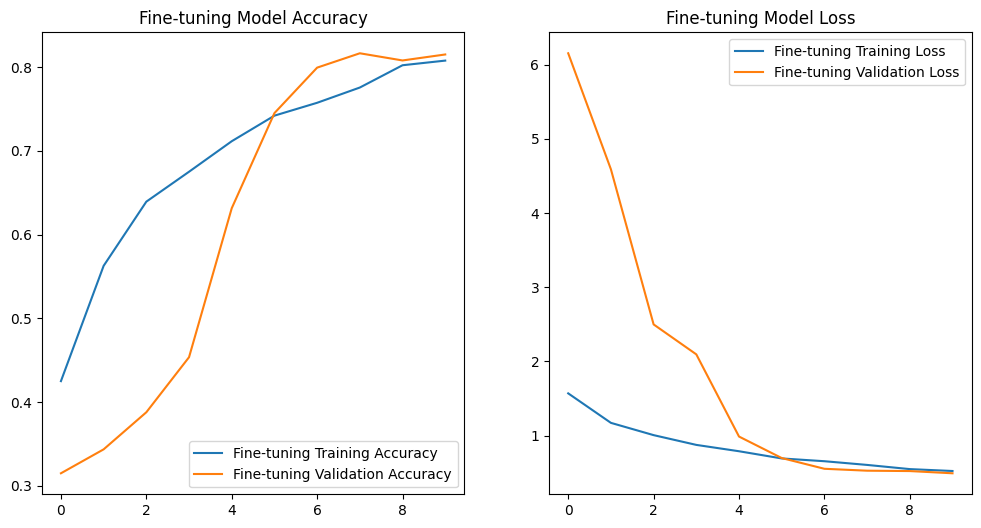

In [17]:
# İnce ayar (Fine-tuning) sonrası modelin eğitim ve doğrulama doğruluğu ile kaybını görselleştirme
plt.figure(figsize=(12, 6))

# İnce ayar sonrası doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Fine-tuning Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.legend()
plt.title("Fine-tuning Model Accuracy")

# İnce ayar sonrası kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Fine-tuning Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-tuning Validation Loss')
plt.legend()
plt.title("Fine-tuning Model Loss")

plt.show()